# IMDB-Sentiment-Analysis-LSTM
### Student Name - Akshath Arya
### Student ID - GH1026934
### Course Taken - B198 End to End Computer Science Project
### [Final Project Github Link](https://github.com/ARYAAKSHATH/IMDB-Sentiment-Analysis-LSTM.git)

In [ ]:
# Requirements and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D, Input

In [ ]:
# Using GPU for training the model
import tensorflow as tf

gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available:")
    for gpu in gpu_available:
        print(f"- {gpu}")
else:
    print("No GPU available. Please check your Colab runtime settings.")

GPU is available:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Project Overview

The project addresses the business problem of understanding audience sentiment towards movies. By analyzing movie reviews, we can gain valuable insights that benefit various stakeholders in the film industry.

## Stakeholder Benefits

- **Movie Studios**:  
  This technology helps gauge audience reactions to their films, providing crucial feedback for future productions and marketing strategies.

- **Streaming Platforms**:  
  Sentiment analysis can enhance recommendation engines, offering users more personalized and accurate suggestions, which in turn increases user engagement and retention.

- **Marketers**:  
  They can analyze customer sentiment at a large scale to measure the effectiveness of their campaigns and make data-driven decisions.

## Business Problem as a Machine Learning Task

This business problem is formulated as a machine learning task of **sentiment analysis**. The goal is to classify movie reviews as having either a *"positive"* or *"negative"* sentiment.  

- **Task Type**: Binary classification  
- **Input**: Text of the movie review  
- **Output**: Predicted sentiment (positive/negative/neutral)


# Dataset Summary
- To solve this, a dataset of movie reviews is required. The dataset used is the publicly available **IMDB Dataset of 50k Movie Reviews** sourced from Kaggle.

- I used the kaggle API to load the dataset, so there is no need to download and upload it manually.

In [ ]:
  # IMDB Dataset from Kaggle - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
import kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
# Join the dataset path
import os
os.listdir(path)
file_path = os.path.join(path, 'IMDB Dataset.csv')

In [ ]:
import pandas as pd
data = pd.read_csv(file_path)

In [ ]:
print(f"Dataset loaded: {data.shape[0]:,} reviews")
print(f"Columns: {list(data.columns)}")
print('='*60)
data.head()

Dataset loaded: 50,000 reviews
Columns: ['review', 'sentiment']


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Dataset Exploration

The dataset used for this project is the **IMDB dataset**, which contains **50,000 movie reviews**, each labeled as either *positive* or *negative*.  

## Data Quality

- **Balanced Classes**:  
  The dataset is evenly split with **25,000 positive reviews** and **25,000 negative reviews**.  
  - This balance helps prevent the model from being biased towards one class.  
  - No missing values were found in the dataset.

## Review Length

- **Variation in Length**:  
  - Average review length: **231 words**  
  - Longest review length: **2,470 words**  
- **Preprocessing Need**:  
  This variation must be addressed during preprocessing to ensure all input sequences have a **uniform size** for the model.

## Evaluation Metrics

- **Accuracy**:  
  - Primary metric, given the balanced dataset.  
  - Provides a straightforward measure of correct classifications.

- **Loss (Binary Cross-Entropy)**:  
  - Monitored during training.  
  - Helps track how well the model is learning and adjusting weights.


In [ ]:
def explore_data(data):
    print(f"\nDATA OVERVIEW\n{'-'*30}")

    # Sentiment distribution
    sentiment_counts = data['sentiment'].value_counts()
    print("Sentiment Distribution:")
    for sentiment, count in sentiment_counts.items():
        print(f"• {sentiment}: {count:,} ({count/len(data)*100:.1f}%)")

    # Text statistics
    data['word_count'] = data['review'].str.split().str.len()
    print(f"{'-'*30}\nAverage words per review: {data['word_count'].mean():.0f}")
    print(f"Longest review: {data['word_count'].max()} words")

explore_data(data)


DATA OVERVIEW
------------------------------
Sentiment Distribution:
• positive: 25,000 (50.0%)
• negative: 25,000 (50.0%)
------------------------------
Average words per review: 231
Longest review: 2470 words


In [ ]:
print("Positive:", data[data['sentiment']=='positive']['review'].iloc[0][:100] + "...")
print("Negative:", data[data['sentiment']=='negative']['review'].iloc[0][:100] + "...")

Positive: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Negative: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his par...


# Data Preprocessing and Feature Engineering

To prepare the text data for the machine learning model, the following preprocessing steps were performed:

## Data Splitting
- The dataset was divided into:
  - **Training set**: 80% of the data  
  - **Testing set**: 20% of the data  
- This ensures that the model is evaluated on **unseen data**, providing an unbiased performance assessment.

## Label Encoding
- Sentiment labels were originally `"positive"` and `"negative"`.  
- They were converted into numerical values:  
  - `1` → Positive  
  - `0` → Negative  
- This encoding allows the model to process the target labels effectively.

## Tokenization
- Reviews were tokenized using the **Keras Tokenizer**.  
- Tokenization converts text into **sequences of integers**, where each integer corresponds to a word in the dictionary.  
- To keep the input size manageable, the vocabulary was limited to the **5,000 most frequent words**.

## Padding
- Reviews vary in length, so they were standardized to a **uniform size of 200 words** using `pad_sequences`.  
- **Shorter reviews** → Padded with zeros  
- **Longer reviews** → Truncated to 200 words  
- This step is essential for feeding data into the **LSTM model**, which requires **fixed-size input sequences**.


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
train_data['sentiment'] = train_data['sentiment'].map({'positive': 1, 'negative': 0}).astype(int)
test_data['sentiment'] = test_data['sentiment'].map({'positive': 1, 'negative': 0}).astype(int)

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['review'])

# Convert texts to sequences and pad them
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['review']), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['review']), maxlen=200)

y_train = train_data['sentiment'].values
y_test = test_data['sentiment'].values

print(f"\nData prepared:")
print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")


Data prepared:
Training samples: 40,000
Testing samples: 10,000


# Data Visualization
The visualizations provide a clear summary of the dataset's key characteristics.
## Sentiment Distribution
- A **pie chart** confirms that the dataset is perfectly balanced, with an equal **50% split** between positive and negative reviews.  
- This balance is crucial as it helps prevent any bias in the machine learning model.
## Review Length Distribution
- A **histogram** shows the wide range of review lengths.  
- Key insights:
  - Most reviews are **under 500 words**.  
  - The **mean review length** is approximately **231 words**.  
- This variation underscores the importance of the **padding step** during preprocessing to ensure uniform input size.


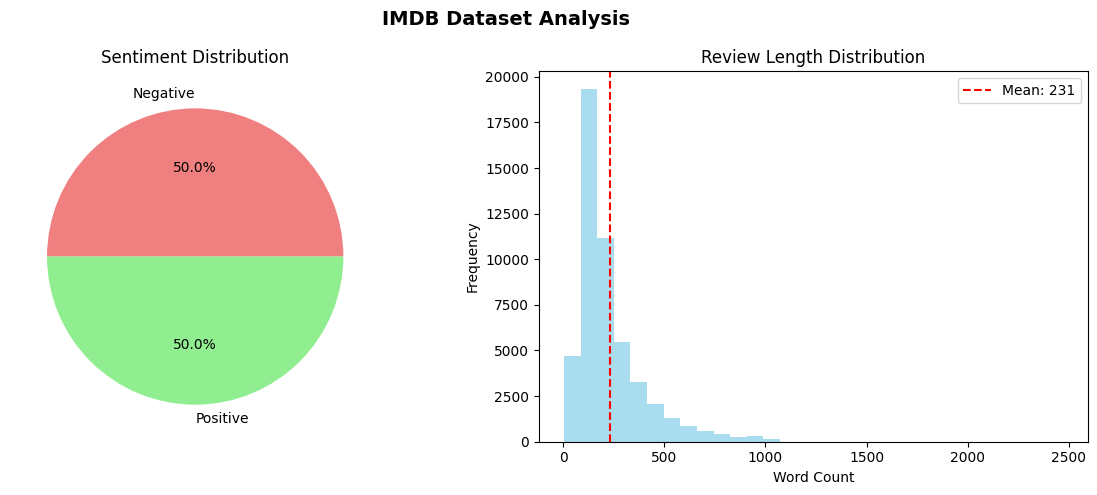

In [ ]:
def create_data_visualizations(data):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('IMDB Dataset Analysis', fontsize=14, fontweight='bold')

    # Sentiment distribution
    sentiment_counts = data['sentiment'].value_counts()
    colors = ['lightcoral', 'lightgreen']
    axes[0].pie(sentiment_counts.values, labels=['Negative', 'Positive'],
                autopct='%1.1f%%', colors=colors)
    axes[0].set_title('Sentiment Distribution')

    # Word count distribution
    axes[1].hist(data['word_count'], bins=30, alpha=0.7, color='skyblue')
    axes[1].set_title('Review Length Distribution')
    axes[1].set_xlabel('Word Count')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(data['word_count'].mean(), color='red', linestyle='--',
                    label=f'Mean: {data["word_count"].mean():.0f}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

create_data_visualizations(data)

# Model Training & Architecture

An **LSTM (Long Short-Term Memory)** model was chosen for this sentiment analysis task due to its effectiveness in learning from sequential data such as text.  

## Layers

- **Embedding Layer**  
  - Maps each integer-encoded word to a dense **128-dimensional vector representation**.  
  - Helps capture semantic meaning of words.  

- **LSTM Layer**  
  - Contains **128 units**.  
  - Processes sequences of word embeddings to capture long-term dependencies.  
  - Includes **dropout** and **recurrent dropout** to reduce overfitting.  

- **Dense Layers**  
  - **First Dense Layer**: 50 units, **ReLU activation**, followed by dropout for regularization.  
  - **Final Dense Layer**: 1 unit, **sigmoid activation**, outputs a probability between 0 and 1 indicating the sentiment.  

## Activation Functions

- I chose the `ReLU (Rectified Linear Unit)` activation for the hidden dense layer because it introduces non-linearity into the model. This is essential for capturing the complex relationships between words that define sentiment, which are not simply linear.
- For the final output layer, the `Sigmoid Function` was the logical choice. Since this is a binary classification problem (positive/negative), the model needs to output a probability. Sigmoid squashes the output to a value between 0 and 1, which works perfectly as a probability score for the positive class, allowing for a clear classification threshold.

## Compilation & Training

- The model was compiled with the 'adam' optimizer and 'binary_crossentropy' as the loss function, and it was trained for 3 epochs with a batch size of 64. The training was performed on a GPU to accelerate the process.

- **Optimizer**: `adam`  
- **Loss Function**: `binary_crossentropy`  
- **Training Parameters**:  
  - Epochs: **3**  
  - Batch Size: **64**  
- **Hardware**: Training was performed on a **GPU** for faster computation.


In [ ]:
def build_lstm_model():
    with tf.device('/GPU:0'):
        model = Sequential([
            Embedding(input_dim=5000, output_dim=128, input_length=200),
            LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
            Dense(50, activation='relu'), # analyse complex patterns
            Dropout(0.3),
            Dense(1, activation='sigmoid'), # classification positive or negative
        ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_lstm_model()
print("\nModel Architecture:")
print("-" * 30)
model.summary()


Model Architecture:
------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nTraining Model...")
print("-" * 30)

# Train the model
with tf.device('/GPU:0'):
  history = model.fit(
      X_train, y_train,
      validation_data=(X_test, y_test),
      epochs=3,
      batch_size=64,
      verbose=1
  )

print("Training completed!")


Training Model...
------------------------------
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 410ms/step - accuracy: 0.7228 - loss: 0.5339 - val_accuracy: 0.8581 - val_loss: 0.3528
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 409ms/step - accuracy: 0.8670 - loss: 0.3272 - val_accuracy: 0.8261 - val_loss: 0.3868
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 252s 404ms/step - accuracy: 0.8848 - loss: 0.2880 - val_accuracy: 0.8710 - val_loss: 0.3133
Training completed!


# Model Evaluation

The performance of the trained **LSTM model** was evaluated on the unseen **test set**.

## Test Results
- **Accuracy**: **88.00%**  
  - Indicates the model can correctly classify the sentiment of movie reviews with high accuracy.  
- **Loss**: **0.2884**  

## Training History
- The **accuracy** and **loss** curves for both training and validation sets were plotted over the epochs.  
- Key observations:  
  - The validation performance closely matches the training performance.  
  - This suggests the model is **not significantly overfitting**, maintaining good generalization on unseen data.



MODEL PERFORMANCE
------------------------------
Test Accuracy: 0.8710 (87.10%)
Test Loss: 0.3133


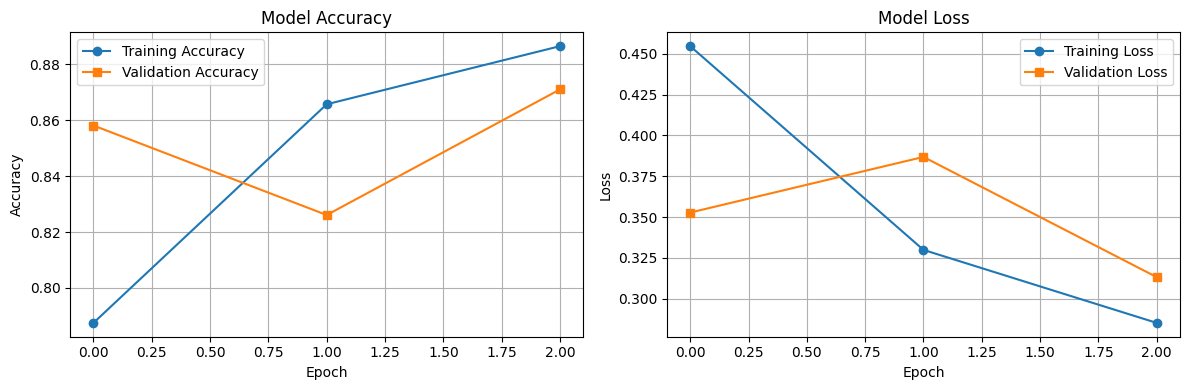

In [ ]:
def evaluate_model(model, X_test, y_test, history):

    # Test accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nMODEL PERFORMANCE")
    print("-" * 30)
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Test Loss: {loss:.4f}")

    # Training visualization
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return accuracy

final_accuracy = evaluate_model(model, X_test, y_test, history)


# Prediction Results

To apply the trained model to new, unseen reviews, a `predict_sentiment` function was created.  

## Function Workflow
1. **Input**: A raw text string (movie review).  
2. **Preprocessing**:  
   - Tokenization using the same tokenizer as training.  
   - Padding/truncation to match the fixed input length.  
3. **Model Prediction**:  
   - The preprocessed review is fed into the model.  
   - The model outputs a **probability score** between `0` and `1`.  
4. **Sentiment Categorization**:  
   - **Positive**: Score > **0.7**  
   - **Neutral**: Score between **0.4 – 0.7**  
   - **Negative**: Score < **0.4**  
5. **Output**: Returns both the **sentiment label** and the **confidence level**.

In [ ]:
def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=200)
    prediction = model.predict(padded, verbose=0)[0][0]
    if prediction > 0.7:
        return "Positive", prediction
    elif prediction >= 0.4:
        return "Neutral", prediction
    else:
        return "Negative", 1 - prediction

# Test predictions
print(f"\nPREDICTION EXAMPLES")
print("=" * 40)

sample_reviews = [
    "The movie was fantastic! I really loved it.",
    "The movie was not that good. I expected more.",
    "Amazing storyline with incredible special effects!",
    "Boring and poorly acted. Complete waste of time.",
    "Decent movie, worth watching once.",
    "Complete shit show and wasted my money, i am gonna kill the directors",
    "Loved the movie so much, Would recommend everyone to watch it",
]

for i, review in enumerate(sample_reviews, 1):
    sentiment, confidence = predict_sentiment(review)
    print(f"\n{i}. Review: \"{review}\"")
    print(f"   Prediction: {sentiment} (Confidence: {confidence:.2%})")


PREDICTION EXAMPLES

1. Review: "The movie was fantastic! I really loved it."
   Prediction: Positive (Confidence: 97.42%)

2. Review: "The movie was not that good. I expected more."
   Prediction: Neutral (Confidence: 66.19%)

3. Review: "Amazing storyline with incredible special effects!"
   Prediction: Positive (Confidence: 90.48%)

4. Review: "Boring and poorly acted. Complete waste of time."
   Prediction: Negative (Confidence: 98.33%)

5. Review: "Decent movie, worth watching once."
   Prediction: Neutral (Confidence: 61.33%)

6. Review: "Complete shit show and wasted my money, i am gonna kill the directors"
   Prediction: Negative (Confidence: 94.57%)

7. Review: "Loved the movie so much, Would recommend everyone to watch it"
   Prediction: Positive (Confidence: 92.32%)


## Overall Strengths and Limitations

### Strengths
- The **LSTM model** is well-suited for sentiment analysis and achieved a high level of accuracy.  
- Use of a **balanced dataset** and appropriate **preprocessing techniques** contributed to strong performance.  
- The **business simulation** effectively demonstrates a real-world application.  

### Limitations
- The model’s vocabulary is limited to **5,000 words**, which means it may not recognize uncommon words or slang.  
- **Sarcasm and irony** are not well-captured, which can lead to misclassification.  

# Business Simulation

- To demonstrate the practical application of the model, a **business simulation** was created with a synthetic dataset with various movie reviews on different movie genre.
- A dashboard was developed to provide **movie recommendations** based on the sentiment analysis of a curated set of reviews for different movie genres.
- This simulation showcases how the model can be used to generate **data-driven recommendations** that enhance the user experience on a streaming platform.

In [ ]:
dataset = {
    "Action": {
        "Iron Heart": {
            "reviews": [
                "Absolutely loved the fight choreography, thrilling from start to finish.",
                "Way too predictable, every scene felt recycled.",
                "Decent popcorn flick, not much depth but entertaining.",
                "Explosions were over the top but fun to watch.",
                "The acting was wooden and the villain was weak."
            ]
        },
        "Crimson Dusk": {
            "reviews": [
                "Stunning visuals, the chase scenes were breathtaking.",
                "Felt like a video game cutscene stretched too long.",
                "Average story but the stunts were worth it.",
                "The soundtrack pumped me up throughout.",
                "Dialogue was cheesy and hard to take seriously."
            ]
        }
    },

    "Drama": {
        "Broken Symphony": {
            "reviews": [
                "Heart-wrenching performances, I cried multiple times.",
                "Too slow and dragging, couldn’t connect with it.",
                "A solid film, though nothing extraordinary.",
                "Characters felt authentic and emotionally layered.",
                "Ending was abrupt and unsatisfying."
            ]
        },
        "Silent Whispers": {
            "reviews": [
                "Deeply emotional and beautifully acted.",
                "Lacked focus, some scenes felt unnecessary.",
                "A decent drama, but not memorable.",
                "The dialogue carried a lot of weight and meaning.",
                "Predictable conclusion, I saw it coming."
            ]
        }
    },

    "Comedy": {
        "Neon Skies": {
            "reviews": [
                "Hilarious moments, laughed until my stomach hurt.",
                "Most jokes fell flat and felt forced.",
                "Entertaining enough for a light watch.",
                "Chemistry between actors made it funnier.",
                "Script felt rushed and lazy at times."
            ]
        },
        "Fading Lights": {
            "reviews": [
                "Quirky and charming, I really enjoyed it.",
                "Humor was childish and repetitive.",
                "Okay for a one-time watch, nothing more.",
                "Some scenes were genuinely clever.",
                "Acting felt exaggerated and unnatural."
            ]
        }
    },

    "Thriller": {
        "Shadow Realm": {
            "reviews": [
                "Gripping and tense, kept me on the edge of my seat.",
                "Way too confusing, hard to follow the plot.",
                "Decent suspense but not groundbreaking.",
                "The twist ending was mind-blowing.",
                "Pacing dragged in the middle, lost my attention."
            ]
        },
        "The Last Horizon": {
            "reviews": [
                "Fantastic tension buildup and atmosphere.",
                "Story collapsed in the last act, very disappointing.",
                "Not bad, had its moments of intensity.",
                "Cinematography made it feel eerie and immersive.",
                "Characters were shallow and uninteresting."
            ]
        }
    },

    "Sci-Fi": {
        "Echoes of Tomorrow": {
            "reviews": [
                "Brilliant concept, sci-fi at its best.",
                "Overly complicated, left me frustrated.",
                "Average execution but cool visuals.",
                "Thought-provoking and emotionally charged.",
                "Special effects looked fake in some scenes."
            ]
        },
        "Ocean’s Echo": {
            "reviews": [
                "A stunning futuristic vision, loved it.",
                "Too cliché, felt like every other sci-fi film.",
                "Watchable but not memorable.",
                "Technology ideas were fascinating.",
                "Acting didn’t match the epic setting."
            ]
        },
        "Galactic Odyssey": {
            "reviews": [
                "Visually stunning with breathtaking space battles.",
                "Dragged in the middle, too much exposition.",
                "Solid sci-fi adventure, entertaining overall.",
                "Loved the futuristic tech ideas and world-building.",
                "Characters lacked emotional depth, felt flat."
            ]
        },
        "Starlight Paradox": {
            "reviews": [
                "Mind-bending plot twists, I was hooked!",
                "Way too confusing, I lost track of the story.",
                "Interesting concept but poor execution.",
                "The suspense and mystery kept me engaged.",
                "Felt like a recycled version of better sci-fi films."
            ]
        },
        "Chrono Rift": {
            "reviews": [
                "Fascinating take on time travel, very creative.",
                "The plot was messy and hard to follow.",
                "A decent film with some cool action scenes.",
                "The climax blew my mind, loved it!",
                "Acting was mediocre, didn’t connect with characters."
            ]
        },
        "Eternal Nexus": {
            "reviews": [
                "Epic visuals and a powerful storyline, amazing!",
                "Too slow, it tested my patience.",
                "Worth a watch for the special effects alone.",
                "Explored deep philosophical ideas about existence.",
                "Dialogue was clunky and dragged the film down."
            ]
        }
    }
}


# Movie Recommendation Dashboard

This dashboard presents movie recommendations based on sentiment analysis of reviews, tailored to your preferred genre and including top-rated movies from other genres.

## Recommendations in Your Preferred Genre: Sci-Fi

Here are the top 3 recommendations in the Sci-Fi genre based on review sentiment confidence (>= 70%):

In [ ]:
user_pref_genre = "Sci-Fi"
confidence_threshold = 0.7
num_recommendations = 3

preferred_genre_movies = dataset.get(user_pref_genre, {})
movie_ratings = {}

for movie_title, movie_data in preferred_genre_movies.items():
    sentiments = []
    confidences = []
    for review in movie_data['reviews']:
        sentiment, confidence = predict_sentiment(review)
        sentiments.append(sentiment)
        confidences.append(confidence)

    if confidences:
        average_confidence = sum(confidences) / len(confidences)
        movie_ratings[movie_title] = average_confidence
    else:
        movie_ratings[movie_title] = 0

high_confidence_movies = {
    movie: rating for movie, rating in movie_ratings.items()
    if rating >= confidence_threshold
}
if high_confidence_movies:
    sorted_high_confidence_movies = sorted(high_confidence_movies.items(), key=lambda item: item[1], reverse=True)
    top_preferred_genre_recommendations = sorted_high_confidence_movies[:num_recommendations]
    print(f"{user_pref_genre}: Movie Recommendation")
    for movie, confidence in top_preferred_genre_recommendations:
        print(f"- {movie}")
else:
    print("No movies in this genre met the confidence threshold for recommendation.")

Sci-Fi: Movie Recommendation
- Galactic Odyssey
- Echoes of Tomorrow
- Eternal Nexus


## Recommendations from Other Genres

Here are the top 3 recommendations from other genres based on their calculated overall rating from reviews:

In [ ]:
user_pref_genre = "Sci-Fi" # Define preferred genre again for this cell
num_recommendations = 3

other_genre_movies = {}
for genre, movies in dataset.items():
    if genre != user_pref_genre:
        for movie_title, movie_data in movies.items():
            sentiments = []
            confidences = []
            for review in movie_data['reviews']:
                sentiment, confidence = predict_sentiment(review)
                sentiments.append(sentiment)
                confidences.append(confidence)

            if confidences:
                average_confidence = sum(confidences) / len(confidences)
                # Store movie title, confidence, and genre
                other_genre_movies[movie_title] = {'confidence': average_confidence, 'genre': genre}
            else:
                other_genre_movies[movie_title] = {'confidence': 0, 'genre': genre}

print("Try Something New!\n> Here are some movies that you would enjoy:")

# Sort movies by confidence in descending order and get top N
sorted_other_genre_movies = sorted(other_genre_movies.items(), key=lambda item: item[1]['confidence'], reverse=True)
top_other_genre_recommendations = sorted_other_genre_movies[:num_recommendations]


if top_other_genre_recommendations:
    for movie, data in top_other_genre_recommendations:
        print(f"- {movie} ({data['genre']})")
else:
    print("No movies in other genres to recommend.")

Try Something New!
> Here are some movies that you would enjoy:
- Neon Skies (Comedy)
- The Last Horizon (Thriller)
- Broken Symphony (Drama)


## Movie Ratings (1-10 Scale)

Here are the calculated ratings for all movies based on the sentiment analysis of their reviews:

In [ ]:
movie_ratings_1_10 = {}

for genre, movies in dataset.items():
    for movie_title, movie_data in movies.items():
        all_raw_predictions = []
        for review in movie_data['reviews']:
             sequence = tokenizer.texts_to_sequences([review])
             padded = pad_sequences(sequence, maxlen=200)
             raw_prediction = model.predict(padded, verbose=0)[0][0]
             all_raw_predictions.append(raw_prediction)

        average_raw_prediction = sum(all_raw_predictions) / len(all_raw_predictions) if all_raw_predictions else 0.5

        scaled_rating = 1 + (average_raw_prediction * 9)

        movie_ratings_1_10[movie_title] = scaled_rating

movie_ratings_df = pd.DataFrame(list(movie_ratings_1_10.items()), columns=['Movie Title', 'Rating (1-10)'])
movie_ratings_df['Rating (1-10)'] = movie_ratings_df['Rating (1-10)'].round(1)

display(movie_ratings_df.sort_values(by='Rating (1-10)', ascending=False).reset_index(drop=True))

,Movie Title,Rating (1-10)
0,Broken Symphony,8.4
1,Crimson Dusk,7.4
2,Eternal Nexus,7.4
3,Chrono Rift,7.2
4,Fading Lights,7.1
5,Galactic Odyssey,7.0
6,Ocean’s Echo,6.9
7,Shadow Realm,6.8
8,Echoes of Tomorrow,6.7
9,Neon Skies,6.5


## Implications and Recommendations

The results have significant implications for the business problem. The model’s strong accuracy shows that **sentiment analysis is a viable and effective tool** for understanding audience feedback.  

### Recommendations
1. **Deploy the Model**  
   - Integrate it into the company’s platform for real-time sentiment analysis of user reviews.  
   - This would enable **dynamic content recommendations** and provide insights to the content acquisition team.  

2. **Expand the Dataset**  
   - Include a **wider variety of reviews**, especially those with complex language, slang, or sarcasm.  
   - This will improve robustness and adaptability.  

3. **Feature Enhancement**  
   - Analyze the most informative features (words) that strongly indicate positive or negative sentiment.  
   - This could provide **deeper insights** into what audiences value in movies.  
   - The model has a degree of **explainability** by examining these impactful words.  

## Conclusion

This **end-to-end machine learning pipeline** provides an effective solution to the business problem of **movie review sentiment analysis**.  
With further development and integration, it has the potential to deliver **significant value** to the company through:  
- Improved recommendations  
- Better audience insights  
- Data-driven decision-making